<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/Basic_Collaborative_Filtering_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv("/content/ratings.csv")

In [5]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
df.userId.nunique()

610

In [7]:
df.movieId.nunique()

9724

In [8]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [9]:
df.shape

(100836, 4)

#### Training Dataset Class Wrapper

In [10]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1]
    def __getitem__(self, item):

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

#### Create the model

In [11]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors

        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # user, movie embedding concat
        self.out = nn.Linear(64, 1)


    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.out(output)

        return output

In [12]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)



In [14]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

dataiter = iter(train_loader)
dataloader_data = next(dataiter)
print(dataloader_data)

{'users': tensor([479, 268, 473,  37]), 'movies': tensor([5816,   24, 1796,  404]), 'ratings': tensor([3, 5, 4, 3])}


In [15]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [16]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


#### Manually run a forward path

In [17]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)


tensor([479, 268, 473,  37])
torch.Size([4])
tensor([5816,   24, 1796,  404])
torch.Size([4])


In [18]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[ 1.2110, -0.3732,  1.2286, -1.1316, -1.4806, -2.2798,  0.0658, -0.2887,
          0.7926, -0.0254, -0.1051,  2.0414, -0.6379, -1.8268, -1.2473,  0.3048,
         -1.2157,  0.0861,  0.4716, -2.3124,  2.1173, -2.0649, -0.7669, -0.9392,
          1.2862,  0.3998,  0.5369,  1.6657,  0.4831,  1.7955,  1.3683, -0.9509],
        [-0.9537, -0.0734, -2.1415,  0.4345,  0.8610, -0.8709,  1.0397, -0.6551,
         -0.3300,  1.2047, -0.3242, -0.4151,  0.3859, -0.5378, -1.2545,  2.0379,
         -1.5245, -0.3763, -0.9989,  0.5193, -0.9722, -1.0558,  0.2617, -0.3756,
         -1.5972, -0.7592,  1.1788, -1.2085,  0.6072,  0.9402,  1.5239, -0.7275],
        [ 1.5115, -1.2805, -0.5506,  0.0095, -0.1649, -1.3020,  1.0267, -1.1422,
          0.7144, -0.4266,  0.5498, -2.1491, -0.3652, -0.4551,  2.0045, -0.2285,
         -1.1536,  0.3449,  0.2171, -1.1420,  1.0088,  1.2323,  0.3530,  0.0971,
         -0.3175,  2.3952,  0.2527, -1.3394,  1.2727,  0.3389, 

In [19]:
output = torch.cat([user_embeds, movie_embeds], dim=1)
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[ 1.2110, -0.3732,  1.2286, -1.1316, -1.4806, -2.2798,  0.0658, -0.2887,
          0.7926, -0.0254, -0.1051,  2.0414, -0.6379, -1.8268, -1.2473,  0.3048,
         -1.2157,  0.0861,  0.4716, -2.3124,  2.1173, -2.0649, -0.7669, -0.9392,
          1.2862,  0.3998,  0.5369,  1.6657,  0.4831,  1.7955,  1.3683, -0.9509,
         -0.1306, -0.4269, -0.2793, -0.4500,  2.4099, -0.0814, -0.5111,  0.2126,
          0.5208, -0.2314,  0.0526,  0.0111, -0.5514, -1.8709,  1.0096, -0.4535,
          1.0382,  0.6484,  0.6300, -0.5066, -0.2344, -1.9529, -0.6005,  0.2694,
          0.6332, -0.6194,  1.5653,  1.2955, -0.4247,  0.3682,  1.6383, -1.3439],
        [-0.9537, -0.0734, -2.1415,  0.4345,  0.8610, -0.8709,  1.0397, -0.6551,
         -0.3300,  1.2047, -0.3242, -0.4151,  0.3859, -0.5378, -1.2545,  2.0379,
         -1.5245, -0.3763, -0.9989,  0.5193, -0.9722, -1.0558,  0.2617, -0.3756,
         -1.5972, -0.7592,  1.1788, -1.2085,  0.6072,  0.9402,  1.5239, 

In [20]:
with torch.no_grad():
    model_output = model(dataloader_data['users'],
                   dataloader_data["movies"])

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[ 0.5482],
        [-0.6667],
        [-0.1980],
        [ 0.8611]]), size: torch.Size([4, 1])


In [21]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([3, 5, 4, 3])
tensor([[3],
        [5],
        [4],
        [3]])
tensor([[ 0.5482],
        [-0.6667],
        [-0.1980],
        [ 0.8611]])
tensor(15)
tensor(-14.4555)


#### Run the training loop

In [22]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"],
                       train_data["movies"]
                      )

        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])


        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 5000 is 0.5044392379552126
epoch 0 loss at step: 10000 is 0.18844594927467406
epoch 0 loss at step: 15000 is 0.11074830259978771
epoch 0 loss at step: 20000 is 0.0868020120137371
epoch 0 loss at step: 25000 is 0.07506202446101233
epoch 0 loss at step: 30000 is 0.07275902805412188
epoch 0 loss at step: 35000 is 0.06454768001306802
epoch 0 loss at step: 40000 is 0.061641026634385344
epoch 0 loss at step: 45000 is 0.06294612180124969
epoch 0 loss at step: 50000 is 0.062101583903003486
epoch 0 loss at step: 55000 is 0.061553953965334224
epoch 0 loss at step: 60000 is 0.057195259292190895
epoch 0 loss at step: 65000 is 0.0595381763227284
epoch 0 loss at step: 70000 is 0.05520999567182735
epoch 0 loss at step: 75000 is 0.05681809131847695
epoch 0 loss at step: 80000 is 0.05723424692908302
epoch 0 loss at step: 85000 is 0.05801951455641538
epoch 0 loss at step: 90000 is 0.0560248064047657


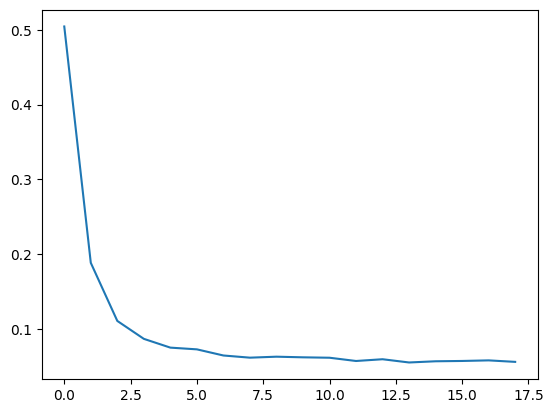

In [23]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

##### Evaluation with RMSE


In [24]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output = model(batched_data['users'],
                       batched_data["movies"])

        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]

        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        #print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

rms: 0.47457454647223885


##### Evaluation with Recall@K


In [25]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']

        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))


Streaming output truncated to the last 5000 lines.
56, 2592, 3.4848074913024902, 5
267, 1660, 3.471447467803955, 3
88, 5813, 3.2487611770629883, 3
379, 4956, 3.6642844676971436, 4
337, 46, 3.4597885608673096, 4
379, 133, 3.6433234214782715, 3
306, 2912, 2.6268787384033203, 3
277, 277, 4.612640380859375, 5
595, 9175, 3.0950779914855957, 3
267, 621, 2.802443027496338, 4
176, 5420, 2.970461845397949, 3
61, 2957, 3.8881869316101074, 4
95, 1290, 3.643824577331543, 2
559, 4419, 2.8885204792022705, 3
474, 7571, 4.068698883056641, 5
409, 704, 4.442724704742432, 5
22, 4926, 3.8348007202148438, 3
311, 2026, 3.0701041221618652, 3
410, 193, 2.744805335998535, 3
386, 3434, 2.6447677612304688, 3
437, 3100, 3.2139809131622314, 3
533, 7035, 2.9950785636901855, 3
248, 1938, 4.247509956359863, 5
218, 2567, 2.4416706562042236, 4
168, 898, 4.417874813079834, 4
201, 46, 4.356190204620361, 4
219, 4090, 3.4554381370544434, 1
464, 2729, 4.268466949462891, 5
598, 1591, 2.406153440475464, 1
593, 472, 3.55823063

In [27]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value.
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 102,  n_rel 20, n_rec_k 10, n_rel_and_rec_k 10
uid 238,  n_rel 20, n_rec_k 10, n_rel_and_rec_k 10
uid 77,  n_rel 4, n_rec_k 1, n_rel_and_rec_k 1
uid 447,  n_rel 56, n_rec_k 0, n_rel_and_rec_k 0
uid 569,  n_rel 6, n_rec_k 6, n_rel_and_rec_k 3
uid 289,  n_rel 20, n_rec_k 10, n_rel_and_rec_k 10
uid 220,  n_rel 24, n_rec_k 10, n_rel_and_rec_k 10
uid 607,  n_rel 27, n_rec_k 0, n_rel_and_rec_k 0
uid 98,  n_rel 3, n_rec_k 7, n_rel_and_rec_k 3
uid 596,  n_rel 24, n_rec_k 10, n_rel_and_rec_k 8
uid 56,  n_rel 27, n_rec_k 5, n_rel_and_rec_k 5
uid 513,  n_rel 22, n_rec_k 0, n_rel_and_rec_k 0
uid 293,  n_rel 9, n_rec_k 0, n_rel_and_rec_k 0
uid 482,  n_rel 49, n_rec_k 10, n_rel_and_rec_k 7
uid 306,  n_rel 18, n_rec_k 0, n_rel_and_rec_k 0
uid 308,  n_rel 10, n_rec_k 8, n_rel_and_rec_k 6
uid 27,  n_rel 12, n_rec_k 0, n_rel_and_rec_k 0
uid 379,  n_rel 66, n_rec_k 10, n_rel_and_rec_k 7
uid 551,  n_rel 10, n_rec_k 1, n_rel_and_rec_k 1
uid 312,  n_rel 18, n_rec_k 8, n_rel_and_rec_k 8
uid 598,  n_rel 2

In [28]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.5609054232804234
recall @ 10 : 0.4685861644021134
